In [1]:
import numpy as np
import scienceplots
import os
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from particle_data_structure import ParticleDataStruct
from confectionery import Confectionery
from cluster_half_shelfs_alpha import Half_shelf_cluster
from scipy.signal import savgol_filter
from matplotlib import cm


# Input Data

In [2]:
folder_name="Gute_aufnahme_shortened"

In [3]:
data_paths=os.listdir(os.path.join("data",folder_name))
stream_string=np.load(os.path.join("data",folder_name,"image_paths_smooth.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)
cut_radius=[int(np.floor(np.mean(x[:,-1])))-1 for x in objs]


In [4]:
koppenrath=Confectionery()
destination_particle_structured3=os.path.join("data",folder_name,"particle_structured3d_")
destination_particle_structured_flat=os.path.join("data",folder_name,"particle_structured_flat_")


In [5]:
structered_datas=[ParticleDataStruct(x,stream_string,c,koppenrath) for x,c in zip(objs,cut_radius)]
particle_datas_3d=[x.create_data_3d() for x in structered_datas]
particle_datas_flat=[x.flatten_data() for x in structered_datas]

In [6]:
for i in range(number_objs):
    structered_datas[i].save_data_3d(destination_particle_structured3+str(i)+".npy")
    structered_datas[i].save_data_flat(destination_particle_structured_flat+str(i)+".npy")

# visualizations

In [8]:
object_id=13
frame_number=int(objs[object_id][0,0])

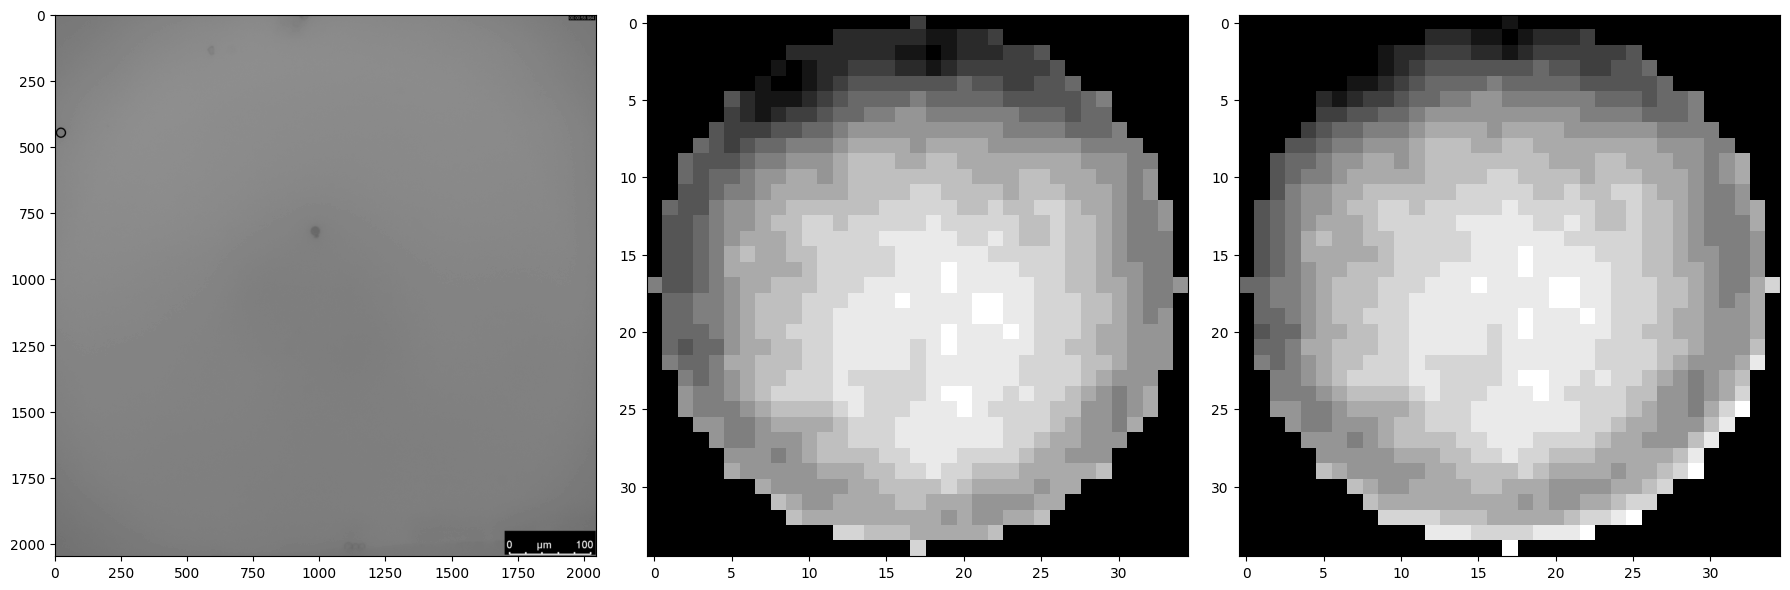

In [9]:
obj_img_test=particle_datas_3d[object_id][0,:,:]
obj_test=objs[object_id][0,:]
big_img_test=cv.cvtColor(np.load(stream_string[frame_number]),cv.COLOR_BGR2GRAY)

r=obj_img_test.shape[0]//2
x_center=round(obj_test[1])
y_center=round(obj_test[2])
s=np.s_[y_center-r:y_center+r+1,x_center-r:x_center+r+1]
obj_img_test_original=np.copy(big_img_test[s])
cv.circle(big_img_test,center=(x_center,y_center),radius=r,color=(0),thickness=3)
M=koppenrath.sell_cake(r,2*r+1,2*r+1)
obj_img_test_original[M==0]=0
vmin=np.min(obj_img_test_original[M==1])
vmax=np.max(obj_img_test_original[M==1])
fig,ax=plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(18)
ax[0].imshow(big_img_test,cmap="gray")
ax[1].imshow(obj_img_test,cmap="gray",vmin=vmin,vmax=vmax)
ax[2].imshow(obj_img_test_original,cmap="gray",vmin=vmin,vmax=vmax)
plt.tight_layout()
plt.show()





In [10]:
structered_data=structered_datas[i]
data_flat=particle_datas_flat[i]
mean_data=np.mean(data_flat,axis=0)
var_data=np.sum((data_flat-mean_data[np.newaxis,:])**2,axis=0)/(mean_data.size-1)
data_flat_normalized=(data_flat-mean_data[np.newaxis,:])/var_data[np.newaxis,:]


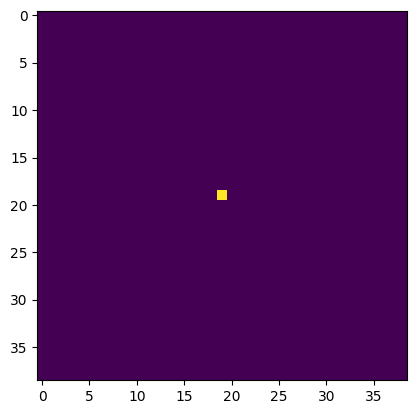

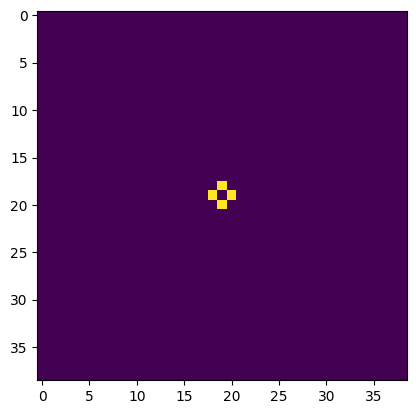

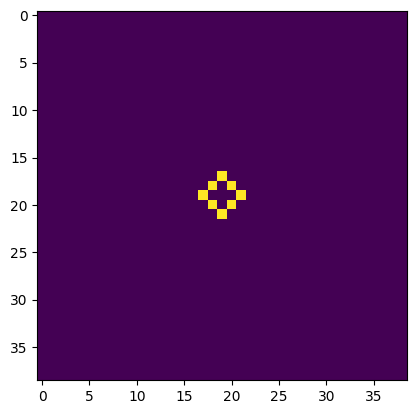

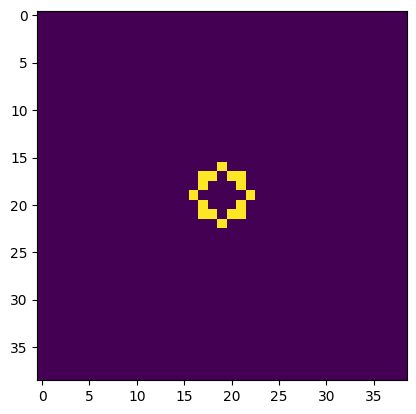

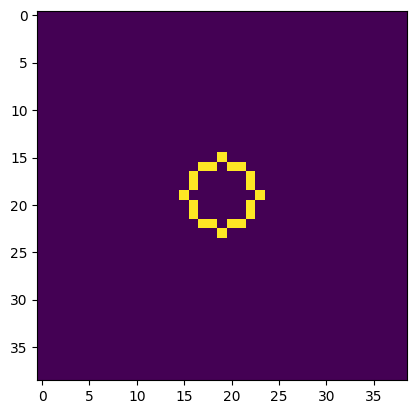

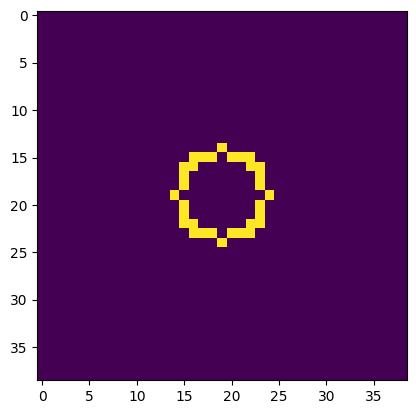

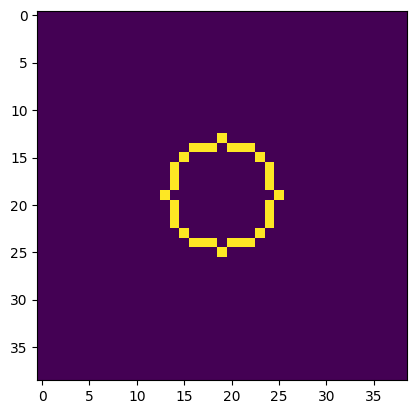

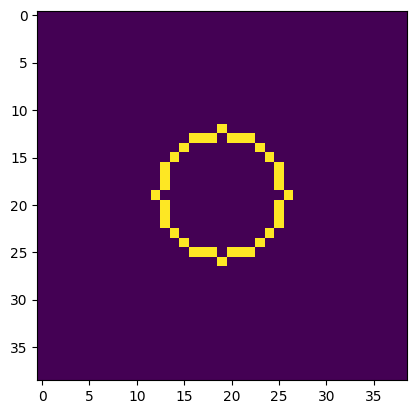

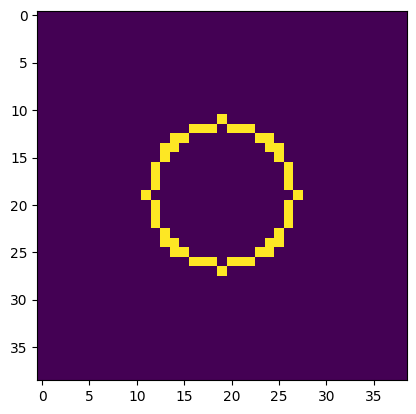

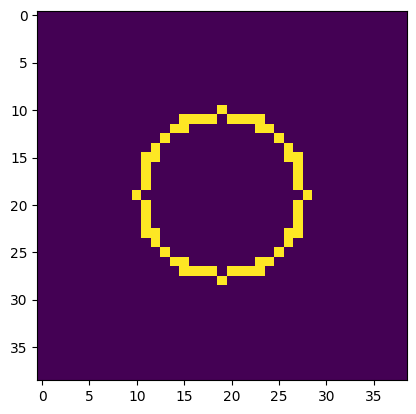

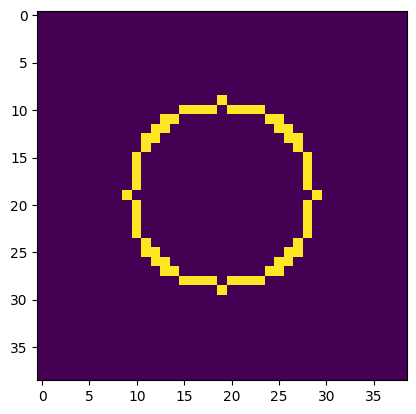

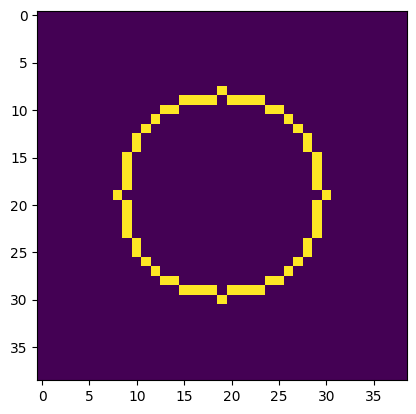

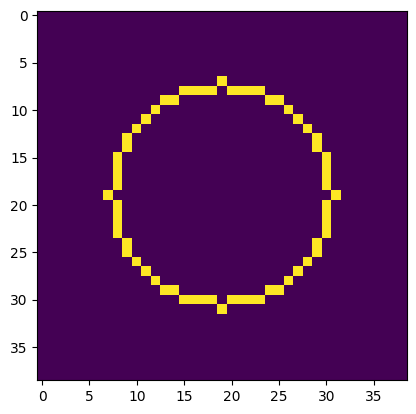

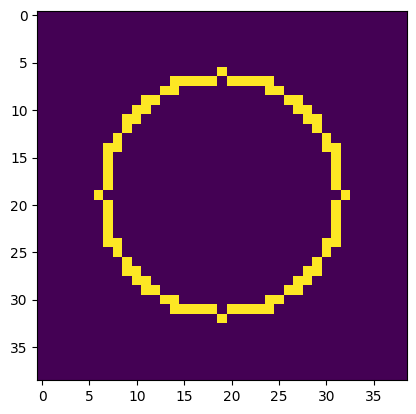

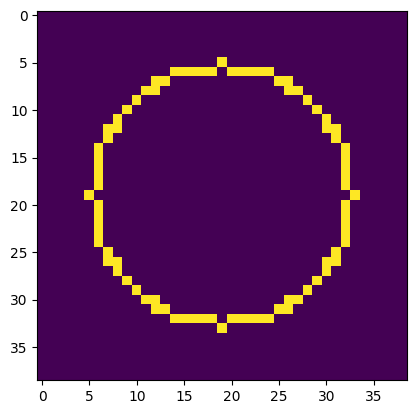

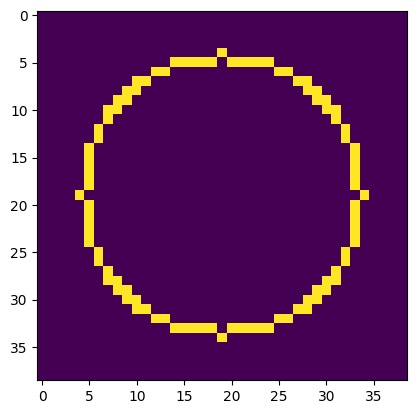

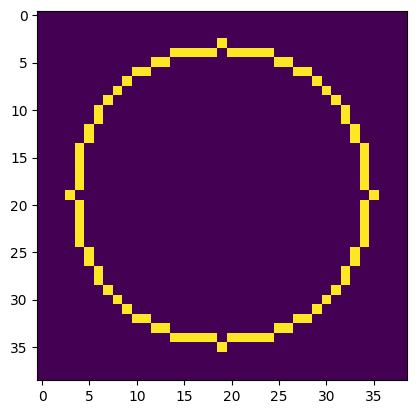

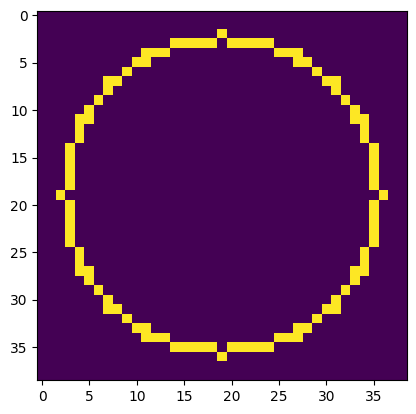

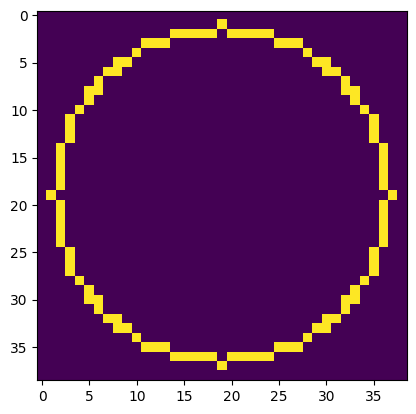

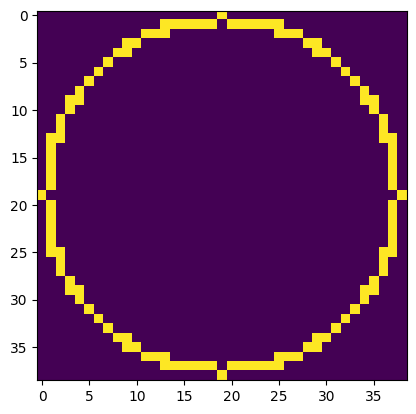

In [11]:
perm=np.zeros(0,dtype=int)
b=np.zeros(0)
for r in range(round(structered_data.r_estimate)+1):
    if r==0:
        M=structered_data.confectionery.sell_cake(r,structered_data.M.shape[1],structered_data.M.shape[0])
    else:
        M=structered_data.confectionery.sell_donut(r,structered_data.M.shape[1],structered_data.M.shape[0])
    plt.figure()
    plt.imshow(M)
    ind_pos=np.flatnonzero(M)
    b=np.append(b,ind_pos.size)
    perm=np.append(perm,ind_pos)

In [12]:
data_expand=structered_data.expand_data(data_flat)
print(data_expand.shape)
data_flat_sorted=data_expand.reshape((data_expand.shape[0],-1))
print(data_flat_sorted.shape)
data_flat_sorted=data_flat_sorted[:,perm]
print(data_flat_sorted.shape)


(68, 39, 39)
(68, 1521)
(68, 1129)


In [13]:
mean_data=np.mean(data_flat_sorted,axis=0)
var_data=np.sum((data_flat_sorted-mean_data[np.newaxis,:])**2,axis=0)/(mean_data.size-1)


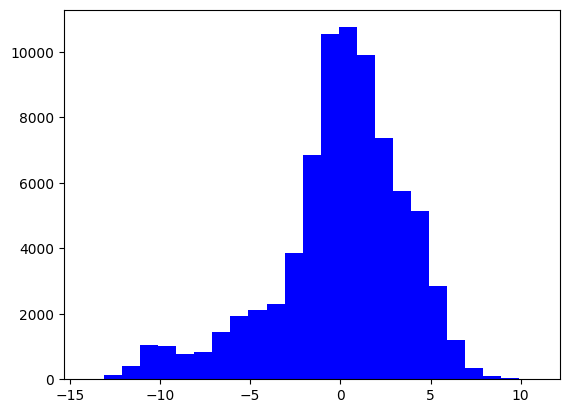

In [14]:
n, bins, patches = plt.hist(data_flat_normalized.reshape(-1), bins=np.arange(min(data_flat_normalized.reshape(-1)), max(data_flat_normalized.reshape(-1)) +1, 1), color = "blue")
plt.show()


[1.000e+00 5.000e+00 1.300e+01 2.900e+01 4.900e+01 8.100e+01 1.130e+02
 1.490e+02 1.970e+02 2.530e+02 3.170e+02 3.770e+02 4.410e+02 5.290e+02
 6.130e+02 7.090e+02 7.970e+02 9.010e+02 1.009e+03 1.129e+03]


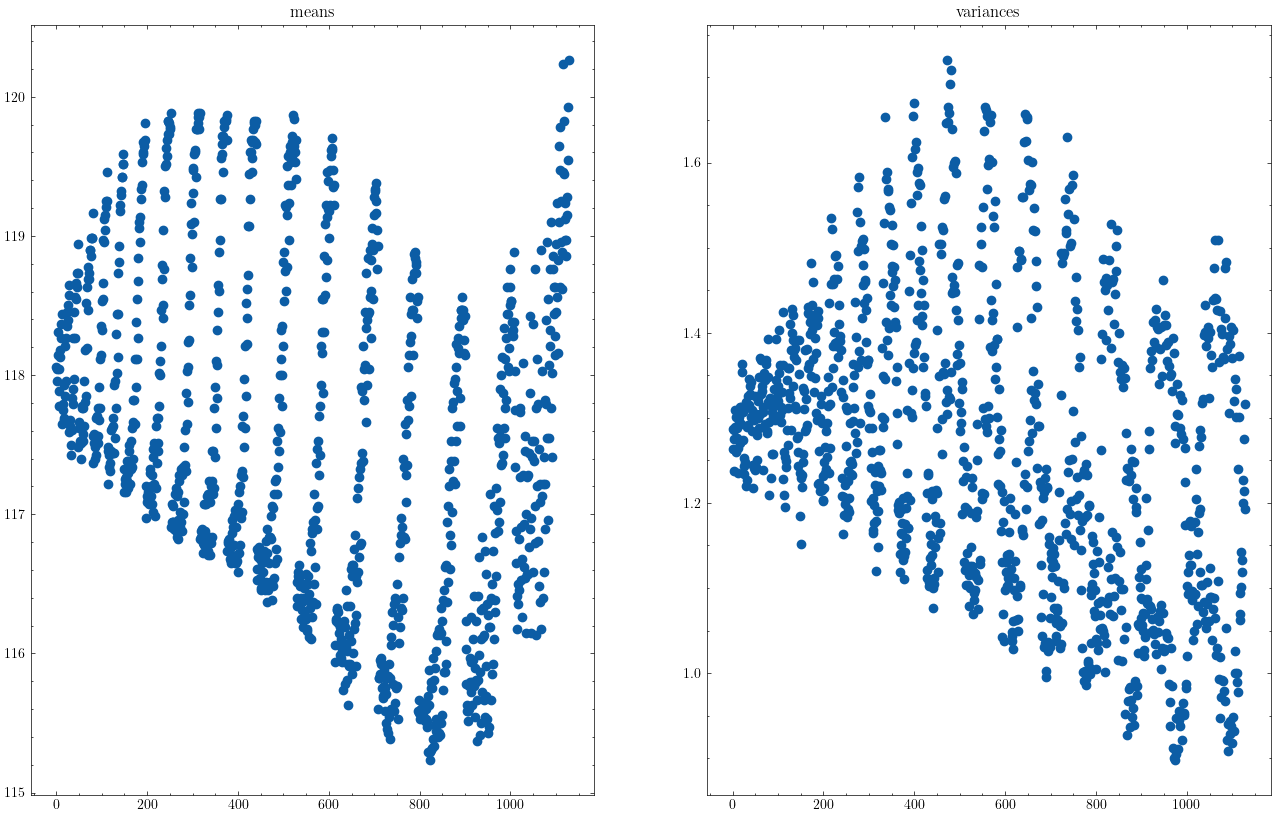

In [15]:
b=np.add.accumulate(b)
print(b)
t=np.arange(mean_data.size)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [16, 10]
    fig,(ax1,ax2)=plt.subplots(1,2)
    ax1.scatter(t,mean_data)
    ax1.set_title("means")
    ax2.scatter(t,var_data)
    ax2.set_title("variances")
    plt.show()